<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
%%bash
pip install --no-cache-dir -qU \
    tensorflow tensorflow-probability tf_keras

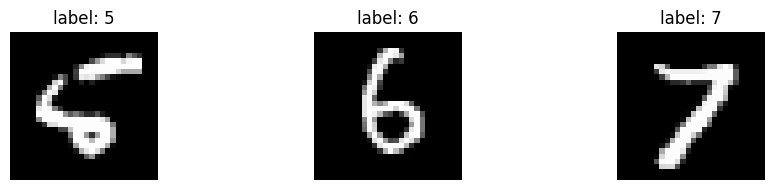

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

class PreprocessingModule(tf.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def __call__(self, x):
        return self.preprocess(inputs=x)
preprocessing = PreprocessingModule(name="preprocessing")

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.map(map_func=lambda x, y: (preprocessing(x=x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 76s
Test loss: 0.0881, Test acc: 0.9775


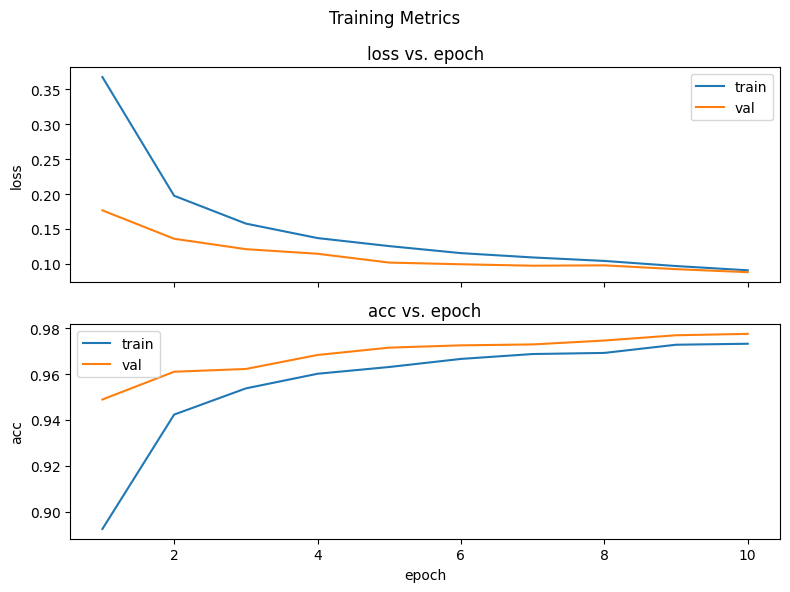

In [ ]:
import os
import tf_keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@tf_keras.saving.register_keras_serializable()
class CustomModel(tf.keras.Model):
    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)
        vars = self.trainable_variables
        grads = tape.gradient(target=loss, sources=vars)
        self.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
        for m in self.metrics:
            if m.name=="loss":
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)
        return {m.name: m.result() for m in self.metrics}

x = tf.keras.Input(shape=(784,), dtype=tf.float32)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=x)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = CustomModel(inputs=x, outputs=y)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

start_time = time.time()
os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
history = model.fit(x=ds_train, validation_data=ds_test,
    epochs=10, verbose=False, callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
            mode="min", patience=1, factor=0.9),
        tf.keras.callbacks.ModelCheckpoint(monitor="val_acc",
            mode="max", save_best_only=True, save_weights_only=True,
            filepath=ckptPath)
])
print("Training duration: %2.fs"%(time.time() - start_time))
loss, acc = model.evaluate(x=ds_test, verbose=False)
print(f"Test loss: %.4f, Test acc: %.4f"%(loss, acc))

df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))
axes[1].set_xlabel(xlabel="epoch")
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, ["loss", "acc"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=m)
    sns.lineplot(ax=ax, label="val", data=df_history,
        x="epoch", y=f"val_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=m)
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

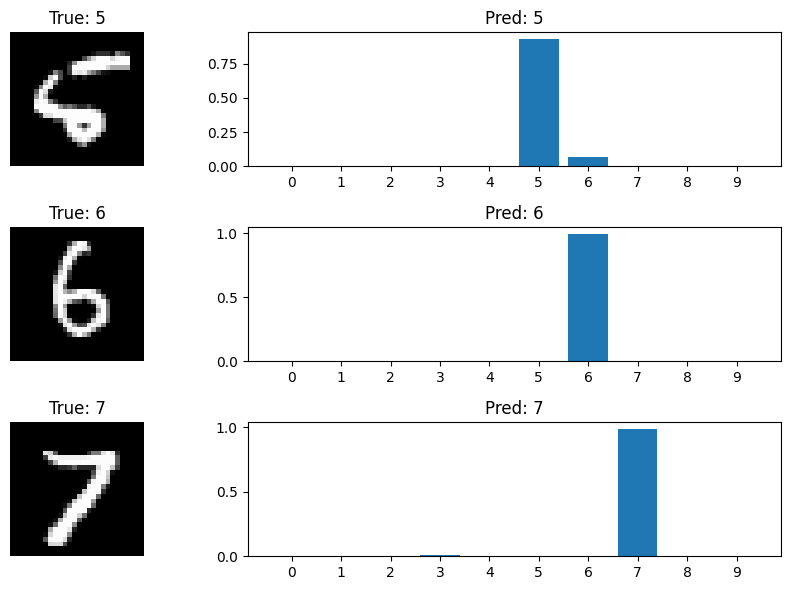

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model.predict(x=preprocessing(x=x_plt), verbose=False)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()

## Models with multiple inputs and outputs

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import model_selection

dataset_url = "https://archive.ics.uci.edu/static/public/184/acute+inflammations.zip"
tf.keras.utils.get_file(fname="acute_inflammations.zip", origin=dataset_url,
    extract=True, cache_dir=".")

names = ["temp", "nocc", "lumbp", "up", "mict", "bis", "inflam", "nephr"]
df_raw = pd.read_csv("datasets/acute_inflammations_extracted/diagnosis.data",
    encoding="utf-16", sep="\t", header=None, names=names)
df_raw['temp'] = df_raw['temp'].str.replace(',', '.').astype(np.float32)
df_train, df_test = model_selection.train_test_split(df_raw,
    test_size=0.1, random_state=42)

      0/Unknown 0s 0s/step

In [ ]:
import tensorflow as tf

class Preprocess(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.function
    def __call__(self, x):
        return x

def get_ds(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=dict(df)).cache()
    # ds = ds.map(map_func=lambda elem: (elem,
    #     ({"inflam": elem.pop("inflam"), "nephr": elem.pop("nephr")})))
    # if shuffle:
    #     ds = ds.shuffle(buffer_size=len(df))
    # ds = ds.batch(batch_size=64)
    # ds = ds.map(map_func=lambda X, y: (X, y),
    #     num_parallel_calls=tf.data.AUTOTUNE)
    # ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(df=df_train, shuffle=True)
ds_test = get_ds(df=df_test, shuffle=False)
ds_test.element_spec

({'temp': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'nocc': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'lumbp': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'up': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'mict': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'bis': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'inflam': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'nephr': TensorSpec(shape=(None,), dtype=tf.string, name=None)})

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed=42)

# Number of unique issue tags
num_tags = 12
# Size of vocabulary obtained when preprocessing text data
num_words = 10000
# Number of departments for predictions
num_departments = 4

num_records = 1280
# Dummy input data
x_title = tf.keras.random.randint(minval=0, maxval=num_words,
    shape=(num_records, 10))
x_body = tf.keras.random.randint(minval=0, maxval=num_words,
    shape=(num_records, 100))
x_tags = tf.cast(x=tf.keras.random.randint(minval=0, maxval=2,
    shape=(num_records, num_tags)), dtype=tf.float32)

# Dummy target data
y_priority = tf.keras.random.uniform(shape=(num_records, 1))
y_dept = tf.keras.random.randint(minval=0, maxval=2,
    shape=(num_records, num_departments))

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

x = {"title": x_title, "body": x_body, "tags": x_tags}
y = {"priority": y_priority, "department": y_dept}
ds_train = get_ds(x=x, y=y, shuffle=True)
ds_train.element_spec

({'title': TensorSpec(shape=(None, 10), dtype=tf.int32, name=None),
  'body': TensorSpec(shape=(None, 100), dtype=tf.int32, name=None),
  'tags': TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)},
 {'priority': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None),
  'department': TensorSpec(shape=(None, 4), dtype=tf.int32, name=None)})

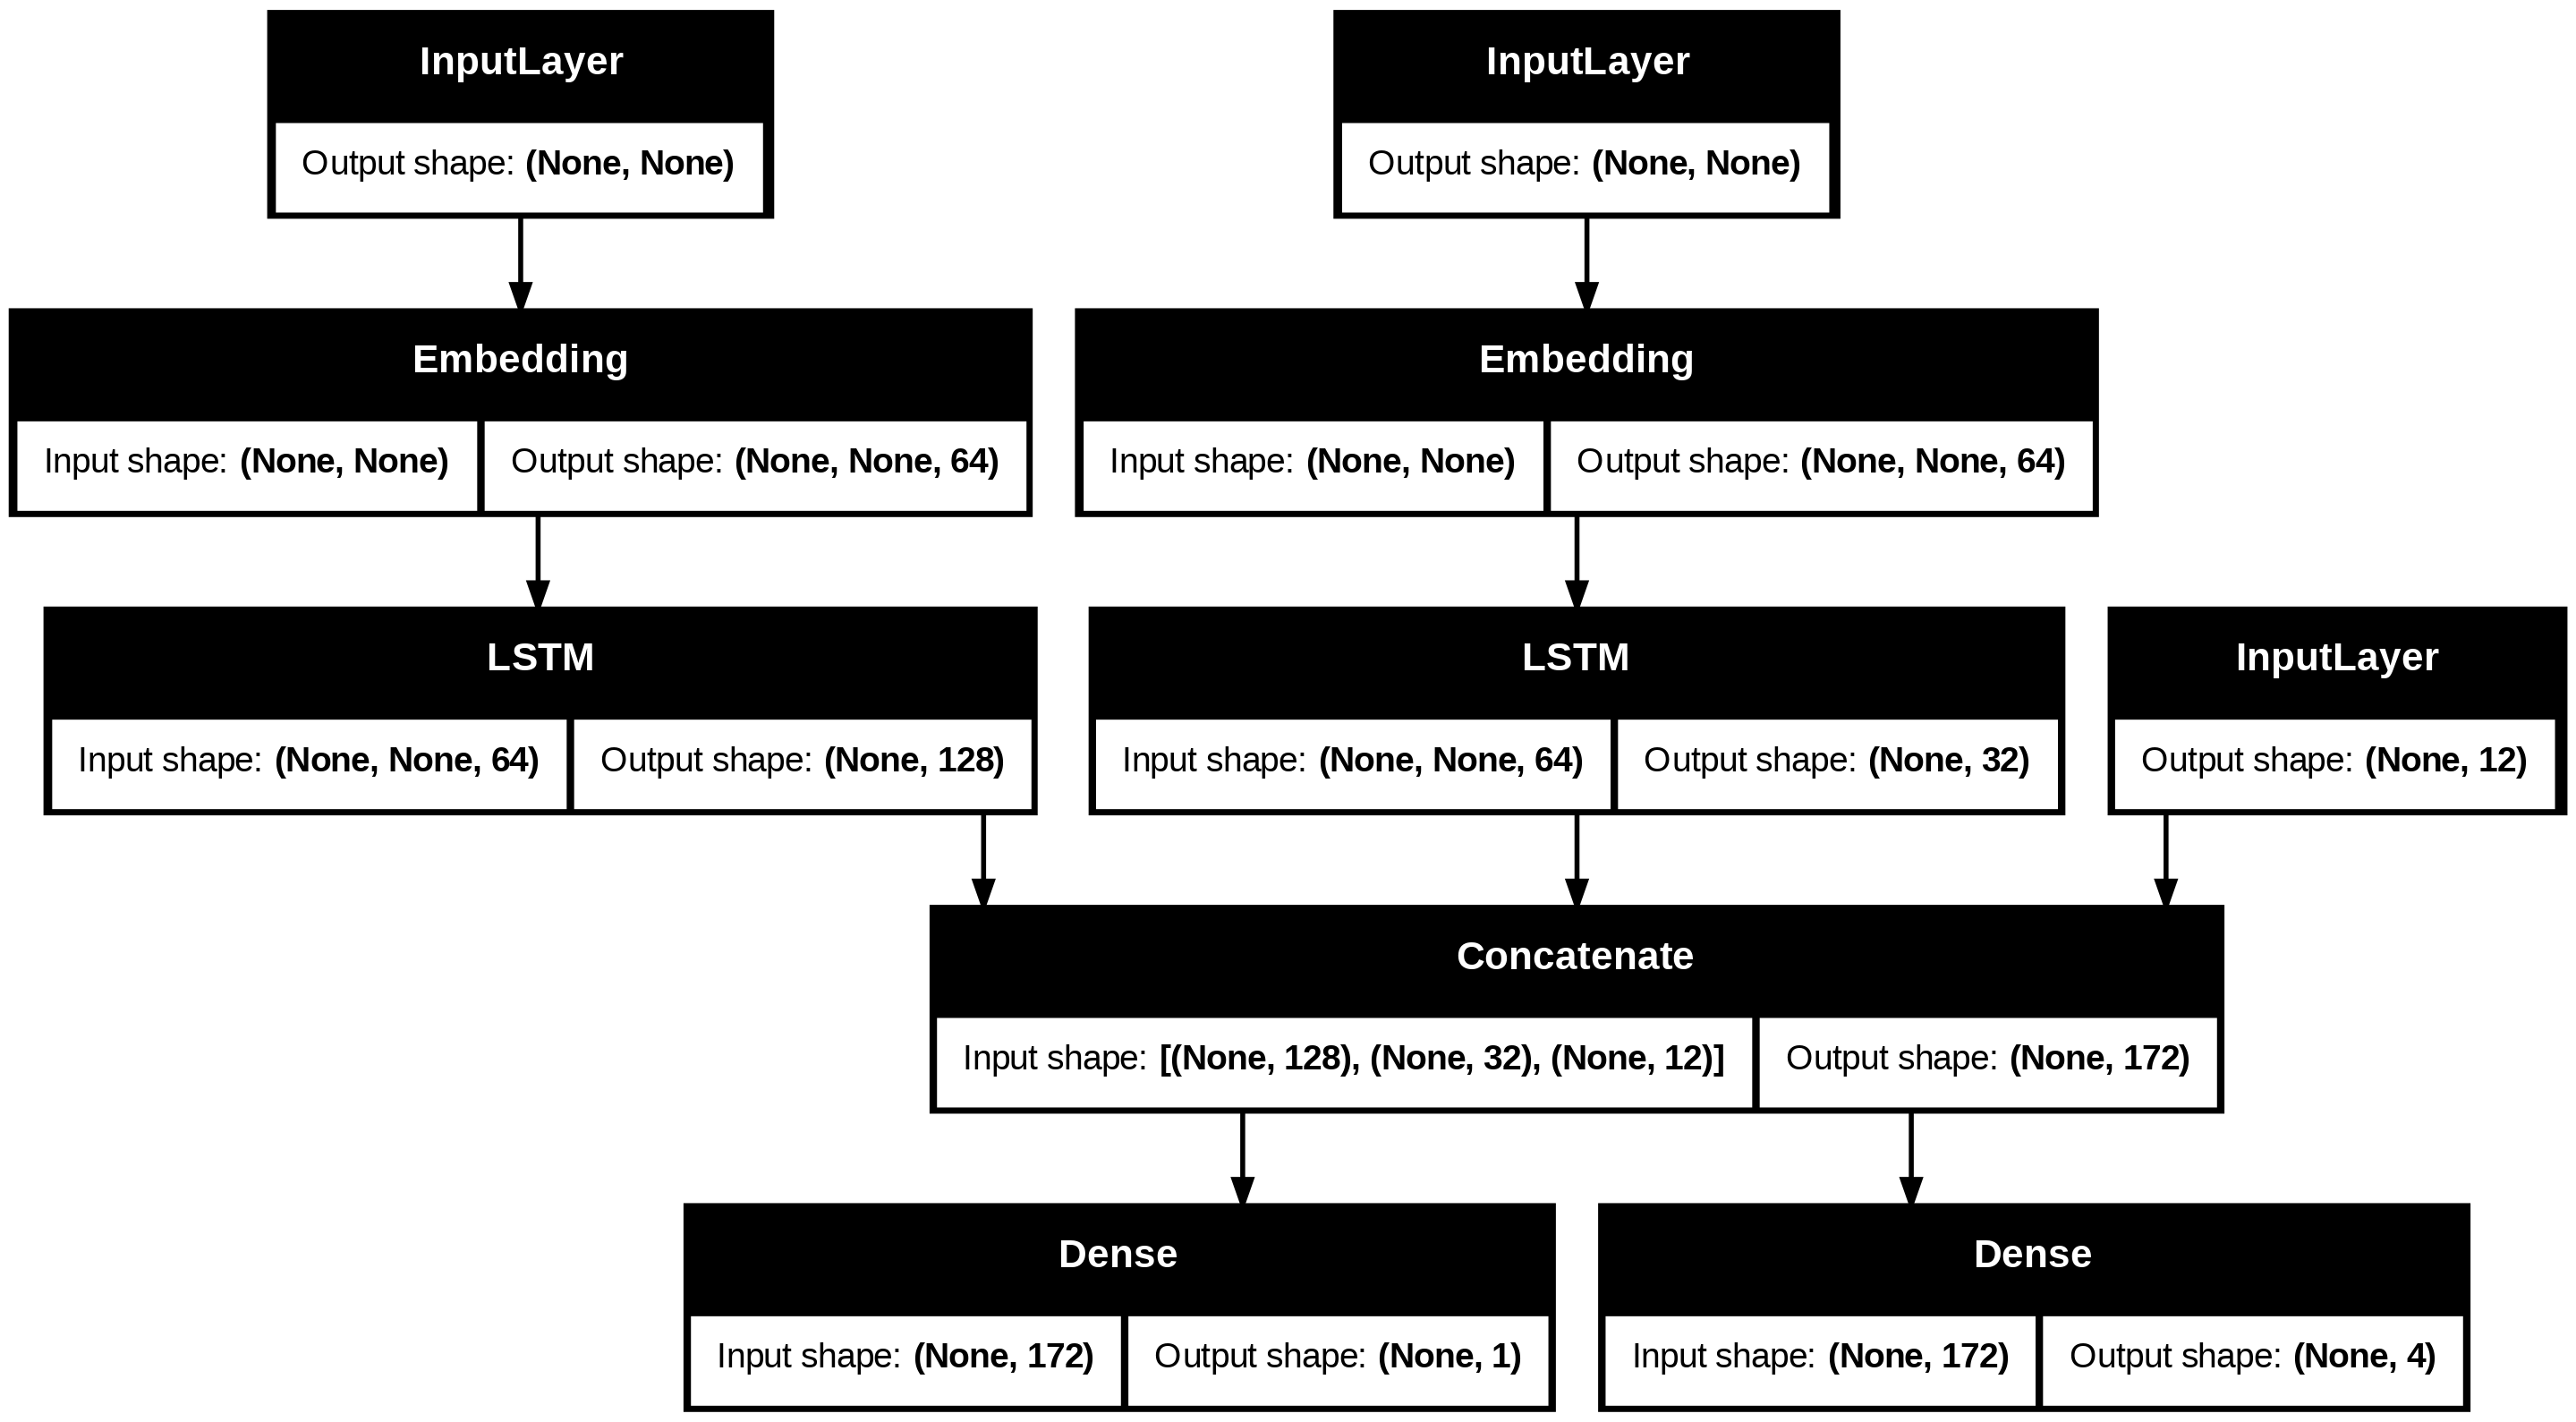

In [ ]:
import tensorflow as tf
tf.random.set_seed(seed=42)

# Variable-length sequence of ints
input_title = tf.keras.Input(shape=(None,), name="title")
# Variable-length sequence of ints
input_body = tf.keras.Input(shape=(None,), name="body")
# Binary vectors of size `num_tags`
input_tags = tf.keras.Input(shape=(num_tags,), name="tags")

# Embed each word in the title into a 64-dimensional vector
feature_title = tf.keras.layers.Embedding(
    input_dim=num_words, output_dim=64)(input_title)
# Embed each word in the text into a 64-dimensional vector
feature_body = tf.keras.layers.Embedding(
    input_dim=num_words, output_dim=64)(input_body)
# Reduce sequence of embedded words in the title into a single 128-dimensional vector
feature_title = tf.keras.layers.LSTM(units=128)(feature_title)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
feature_body = tf.keras.layers.LSTM(units=32)(feature_body)

# Merge all available features into a single large vector via concatenation
x = tf.keras.layers.concatenate([feature_title, feature_body, input_tags])

# Stick a logistic regression for priority prediction on top of the features
pred_priority = tf.keras.layers.Dense(
    units=1, name="priority")(x)
# Stick a department classifier on top of the features
pred_department = tf.keras.layers.Dense(
    units=num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = tf.keras.Model(
    inputs=[input_title, input_body, input_tags],
    outputs=[pred_priority, pred_department],
)
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss={
        "priority": tf.keras.losses.BinaryCrossentropy(from_logits=True),
        "department": tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    },
    loss_weights={"priority": 1.0, "department": 0.2},
    metrics={
        "priority": tf.keras.metrics.BinaryAccuracy(
            name="accuracy"),
        "department": tf.keras.metrics.CategoricalAccuracy(
            name="accuracy")
    }
)
tf.keras.utils.plot_model(model=model, show_shapes=True)

In [ ]:
history = model.fit(x=ds_train, epochs=10)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - department_accuracy: 0.1596 - department_loss: 2.7862 - loss: 1.2609 - priority_accuracy: 0.0000e+00 - priority_loss: 0.7036
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - department_accuracy: 0.2501 - department_loss: 2.8117 - loss: 1.2663 - priority_accuracy: 0.0000e+00 - priority_loss: 0.7039
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - department_accuracy: 0.2724 - department_loss: 2.8195 - loss: 1.2680 - priority_accuracy: 0.0000e+00 - priority_loss: 0.7041
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - department_accuracy: 0.2694 - department_loss: 2.8081 - loss: 1.2638 - priority_accuracy: 0.0000e+00 - priority_loss: 0.7022
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - department_accuracy: 0.2831 - department_loss: 2.8001 - loss: 1.2621 - priority_accuracy: 0.0000e+00 - priority_loss: 0.7021
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - department_accuracy: 0.2939 - department_loss: 2.7939 -